In [12]:
import taichi as ti
from setup.voxel_setup import setup_voxel_scene
from simulation.simulator import *
from common.plot import Plotter
from common.octree import Octree

# debug=True to check boundary access
ti.init(arch=ti.gpu)

import numpy as np
import matplotlib
from scipy import ndimage

%load_ext autoreload
%autoreload 2

# matplotlib.use('Qt5Agg')
%matplotlib widget

[Taichi] Starting on arch=cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load voxel model

In [13]:
NUM_X, NUM_Y, NUM_Z = 128, 128, 128
scene, floor_height = setup_voxel_scene(NUM_X, NUM_Y, NUM_Z)

Loaded Voxel shape: (128, 128, 128)  from: ./assets/bun_zipper_res4.ply
Number of filled voxels: 13849
Loaded Voxel shape: (128, 128, 128)  from: ./assets/wine_glass.obj
Number of filled voxels: 9035
Floor Ratio: -0.3125 , Floor Height: 44


In [14]:
# scene.finish()

## 2. Light simulation

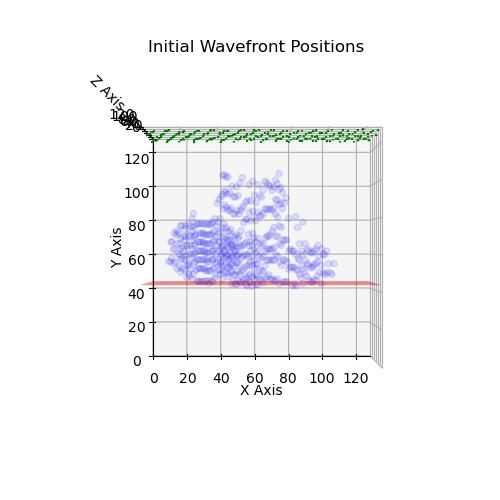

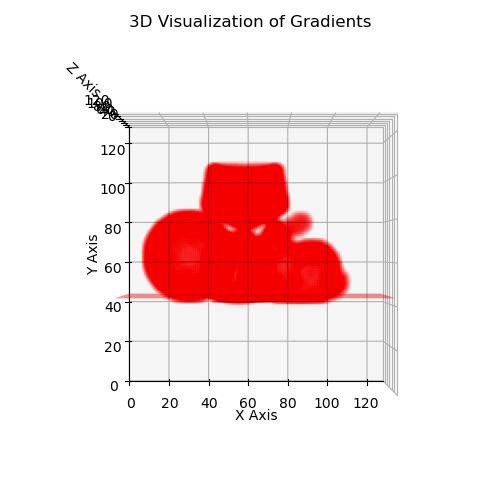

In [15]:
assert scene.ior.shape == (NUM_X, NUM_Y, NUM_Z), "The scene IOR should be a NumPy array of shape (NUM_X, NUM_Y, NUM_Z)"

sampler_multiplier = 3
pos_perturbation_scale = 0.45
initial_wavefront_pos, initial_wavefront_dir = generate_initial_wavefront(sampler_multiplier, pos_perturbation_scale, NUM_X, NUM_Y, NUM_Z)

scene.ior = ndimage.gaussian_filter(scene.ior, sigma=3.0, radius=1)
scene.gradient = compute_ior_gradient(scene.ior)

plotter = Plotter(sampler_multiplier, floor_height, scene.ior)
plotter.plot_wavefront_position(initial_wavefront_pos, initial_wavefront_dir, title="Initial Wavefront Positions")
plotter.plot_gradient(scene.gradient, threshold=0.01, alpha=0.01)

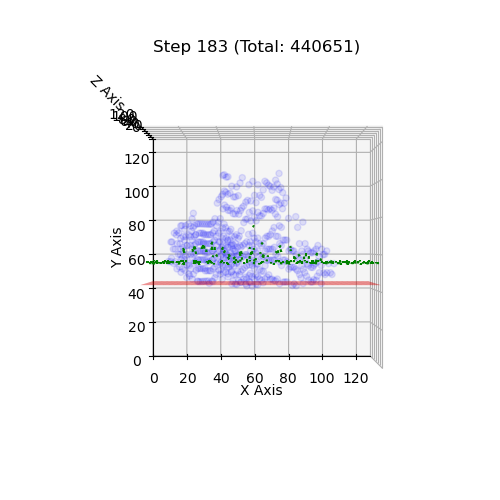

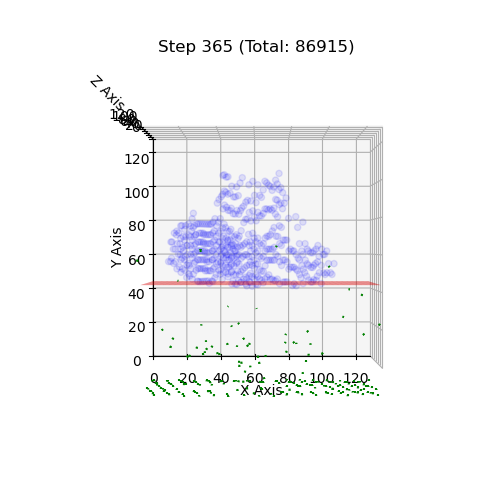

In [16]:
test_delta_t = 0.3 * (NUM_Y / 100)
test_num_steps = int(1.1 * (NUM_Y / test_delta_t))
scene.irradiance, scene.local_diretion = simulate_wavefront_propagation(scene.ior, scene.gradient, scene.attenuation,
                                                initial_wavefront_pos, initial_wavefront_dir,
                                                plotter, test_num_steps, test_delta_t)

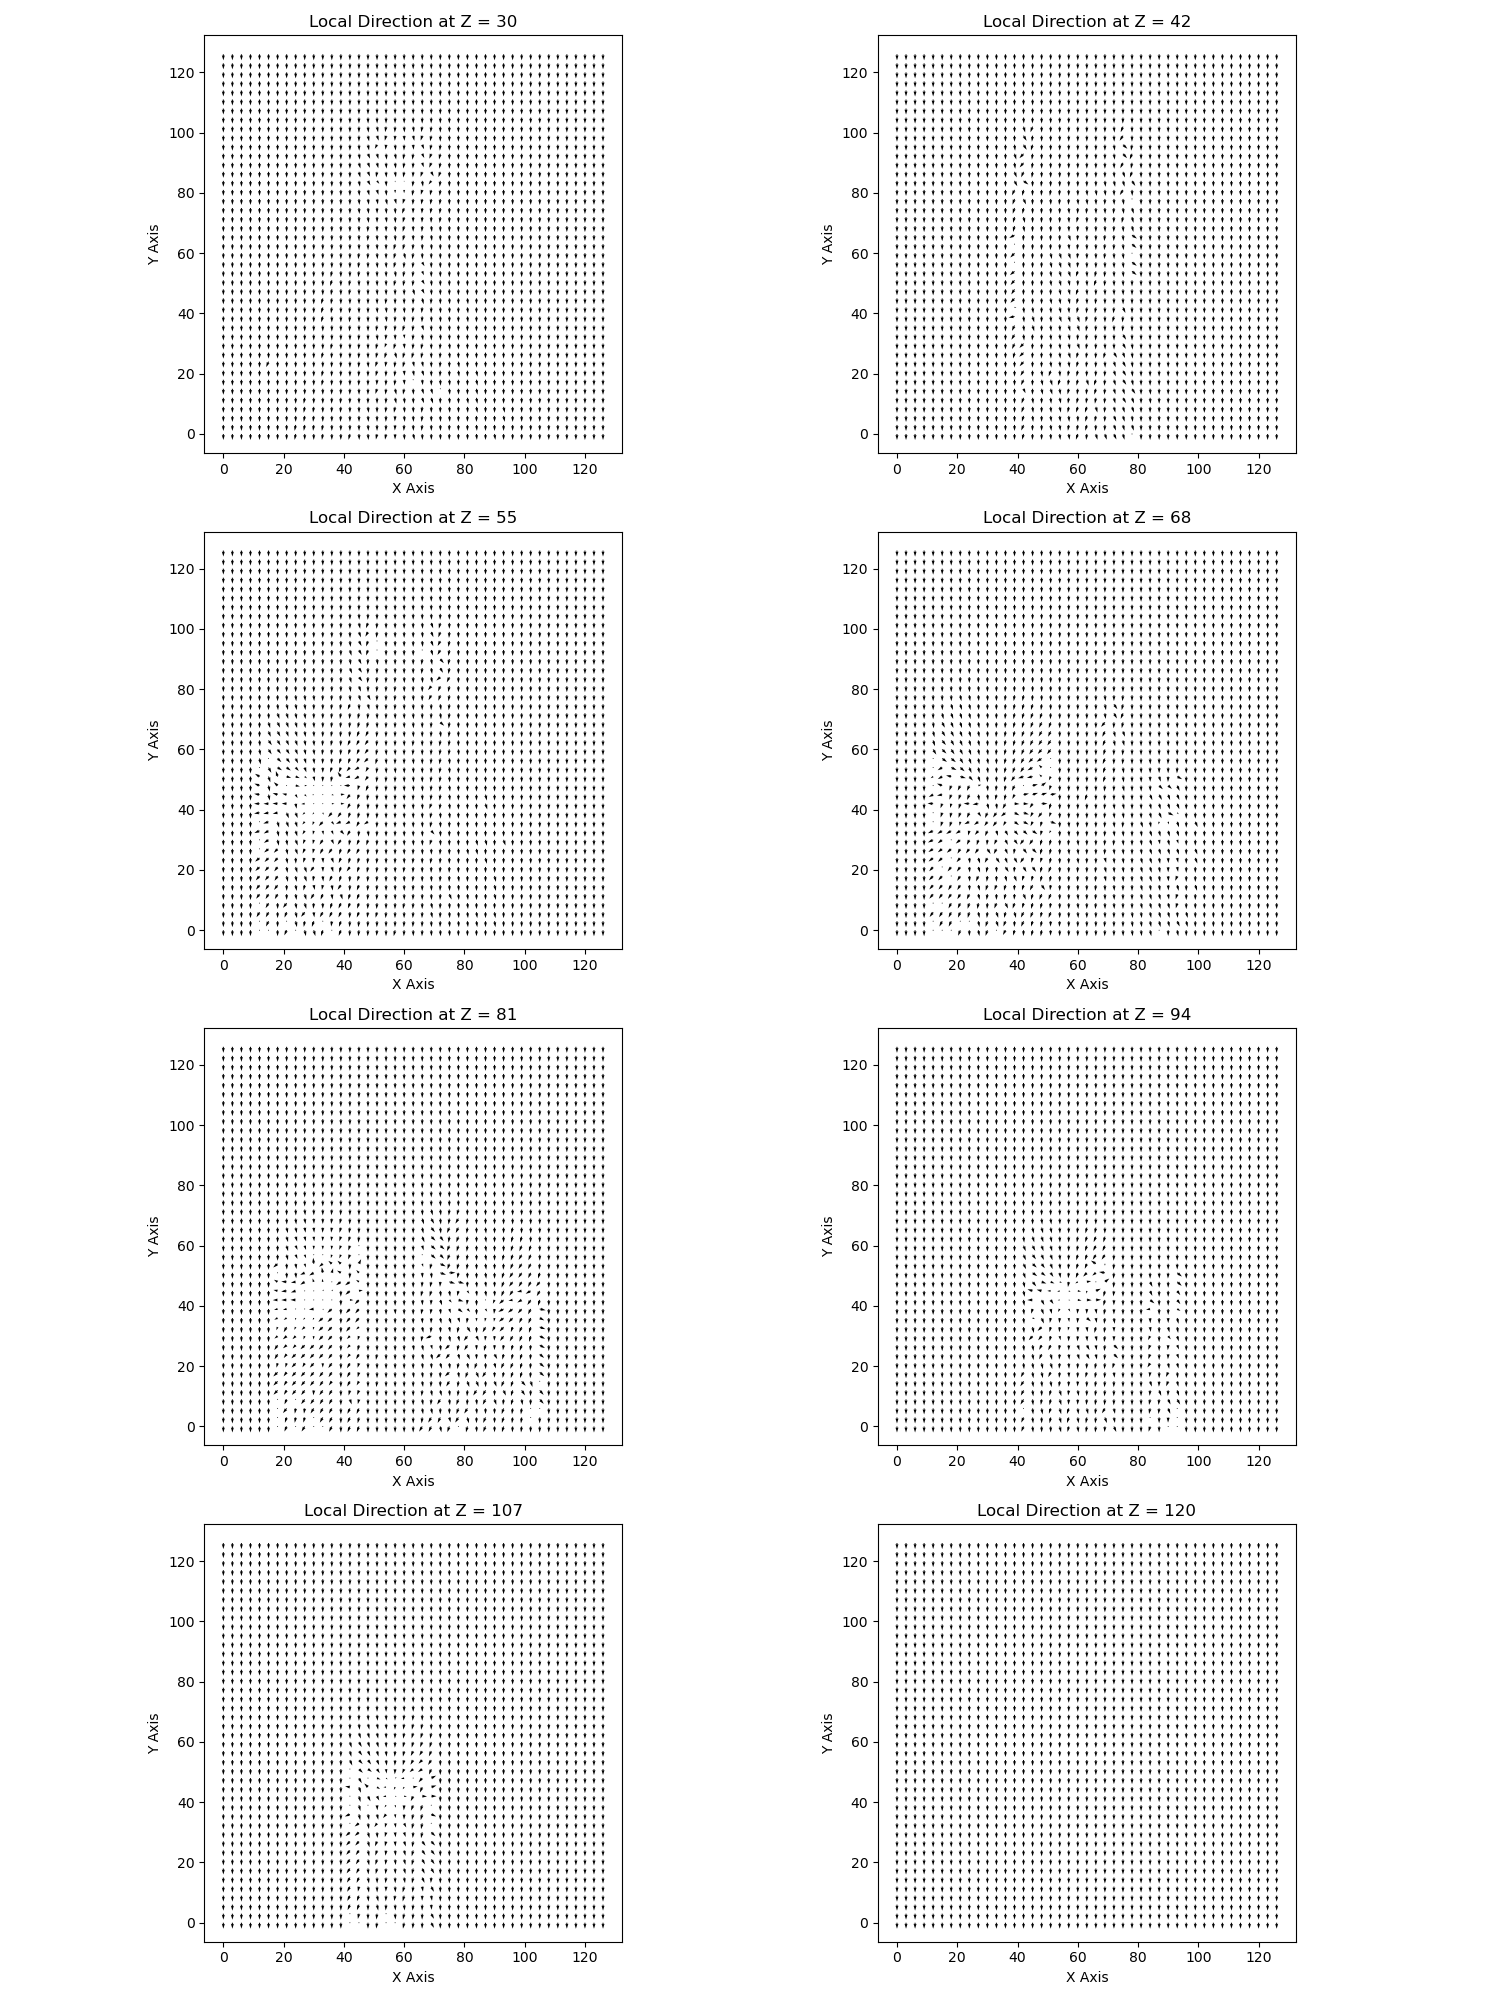

In [17]:
plotter.plot_local_direction_grid_slices(scene.local_diretion, num_slices=8, z_start=30, z_end=120, stream_plot=False)

## 3. Visualise irradiance

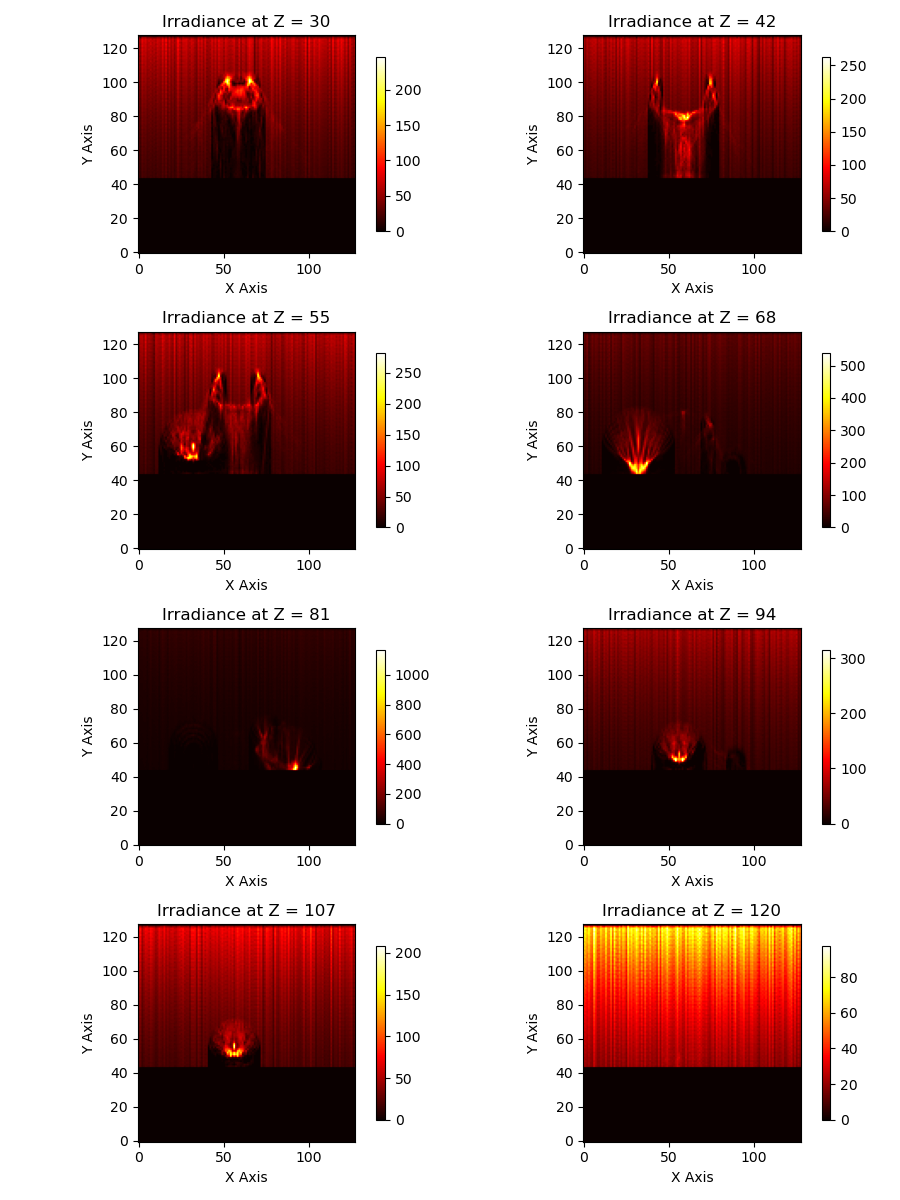

In [18]:
# plotter.plot_irradiance_grid(irradiance_grid, threshold=5*sampler_multiplier**3)
scene.irradiance = remove_under_floor(scene.irradiance, floor_height=floor_height)
plotter.plot_irradiance_slices(scene.irradiance, threshold=3, num_slices=8, z_start=30, z_end=120)

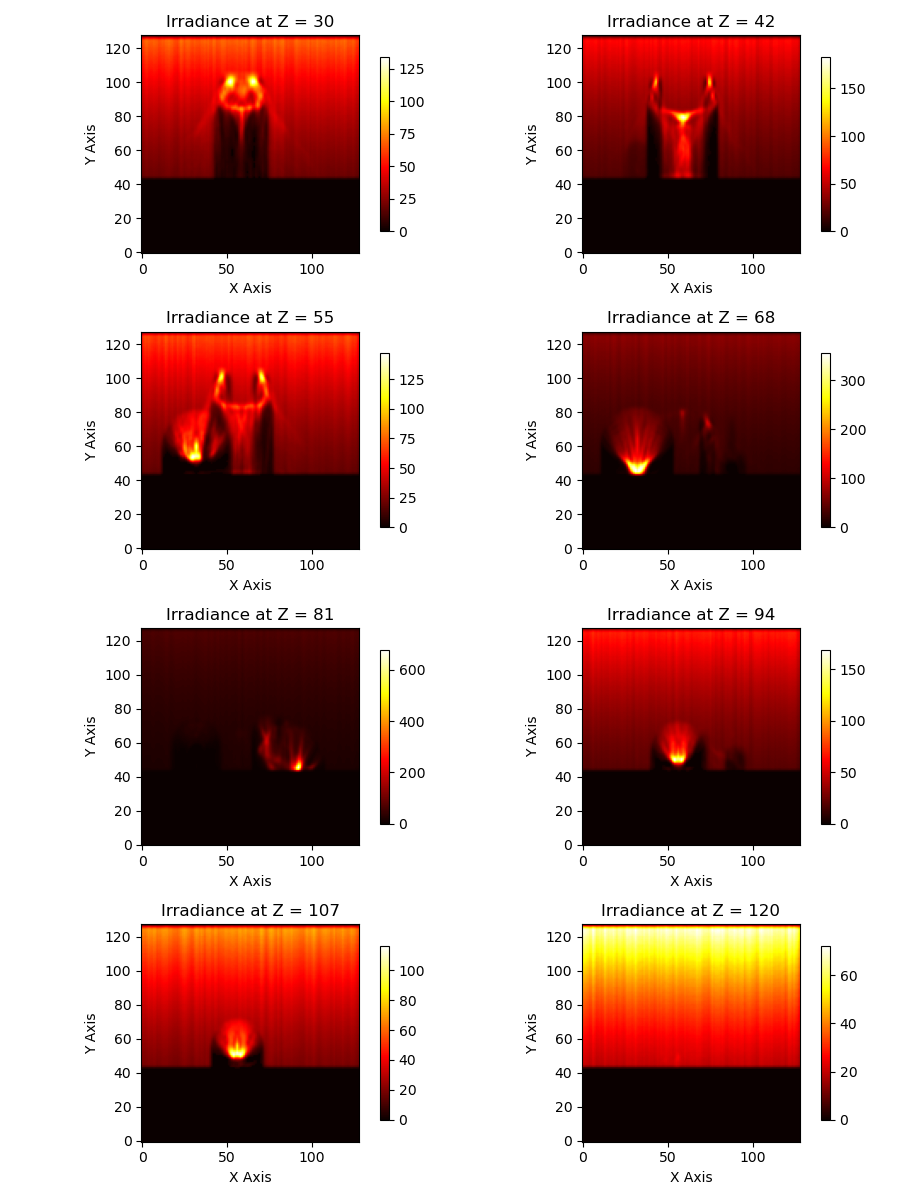

In [19]:
# Apply Gaussian filter to smooth the radiometric grid
scene.irradiance = ndimage.gaussian_filter(scene.irradiance, sigma=0.8) 
plotter.plot_irradiance_slices(scene.irradiance, threshold=3, num_slices=8, z_start=30, z_end=120)

## 6. Neural network irradiance （MLP）

In [28]:
SEED = 42
import torch.nn as nn
class IrradianceNet(nn.Module):
    def __init__(self):
        super(IrradianceNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                
    def forward(self, x):
        return self.model(x).squeeze()

def prepare_data(irradiance: np.ndarray, train_ratio=0.90) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    irradiance_tensor = torch.tensor(irradiance, dtype=torch.float32)
    x = np.arange(irradiance_tensor.shape[0])
    y = np.arange(irradiance_tensor.shape[1]) 
    z = np.arange(irradiance_tensor.shape[2])
    X, Y, Z = np.meshgrid(x, y, z)
    inputs = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)
    targets = irradiance_tensor.flatten()

    inputs = torch.from_numpy(inputs).float().to(DEVICE)
    targets = targets.clone().detach().to(DEVICE)

    # Random shuffle
    # torch.manual_seed(SEED)
    indices = torch.randperm(len(inputs))
    inputs = inputs[indices]
    targets = targets[indices]

    # Split into training and validation sets
    train_size = int(train_ratio * len(inputs))
    train_inputs, val_inputs = inputs[:train_size], inputs[train_size:]
    train_targets, val_targets = targets[:train_size], targets[train_size:]

    return train_inputs, val_inputs, train_targets, val_targets

def train_model(model: IrradianceNet, train_inputs: torch.Tensor, val_inputs: torch.Tensor, train_targets: torch.Tensor, val_targets: torch.Tensor, 
                num_epochs=100, batch_size=1024, patience=40):
    torch.cuda.empty_cache()
    print("Device:", DEVICE)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(train_inputs), batch_size):
            batch_inputs = train_inputs[i:i+batch_size]
            batch_targets = train_targets[i:i+batch_size]
            
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
        
        if val_loss < best_val_loss * 0.95: # when at least 5% improvement, update the best model
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model = model.state_dict()
            print(f"Current best model is at epoch {epoch + 1} and val loss: {val_loss.item():.4f}")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch + 1}')
            break
        
        if (epoch + 1) % 40 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    assert best_model is not None
    print("Final best model's best val loss:", best_val_loss)
    model.load_state_dict(best_model)
    torch.cuda.empty_cache()
    return model

train_inputs, val_inputs, train_targets, val_targets = prepare_data(scene.irradiance)
model = IrradianceNet().to(DEVICE)  
model = train_model(model, train_inputs, val_inputs, train_targets, val_targets, num_epochs=100)

Device: cuda
Current best model is at epoch 1 and val loss: 121.3247
Current best model is at epoch 4 and val loss: 90.4208
Current best model is at epoch 5 and val loss: 83.9366
Current best model is at epoch 7 and val loss: 75.9016
Current best model is at epoch 9 and val loss: 68.9103
Current best model is at epoch 10 and val loss: 57.6436
Current best model is at epoch 14 and val loss: 47.6232
Current best model is at epoch 17 and val loss: 44.1673
Current best model is at epoch 25 and val loss: 41.1592
Current best model is at epoch 29 and val loss: 39.0104
Current best model is at epoch 37 and val loss: 32.6070
Epoch [40/100], Train Loss: 30.7427, Val Loss: 50.7378
Current best model is at epoch 47 and val loss: 27.9780
Current best model is at epoch 64 and val loss: 23.7624
Current best model is at epoch 78 and val loss: 21.9807
Epoch [80/100], Train Loss: 17.0222, Val Loss: 39.7962


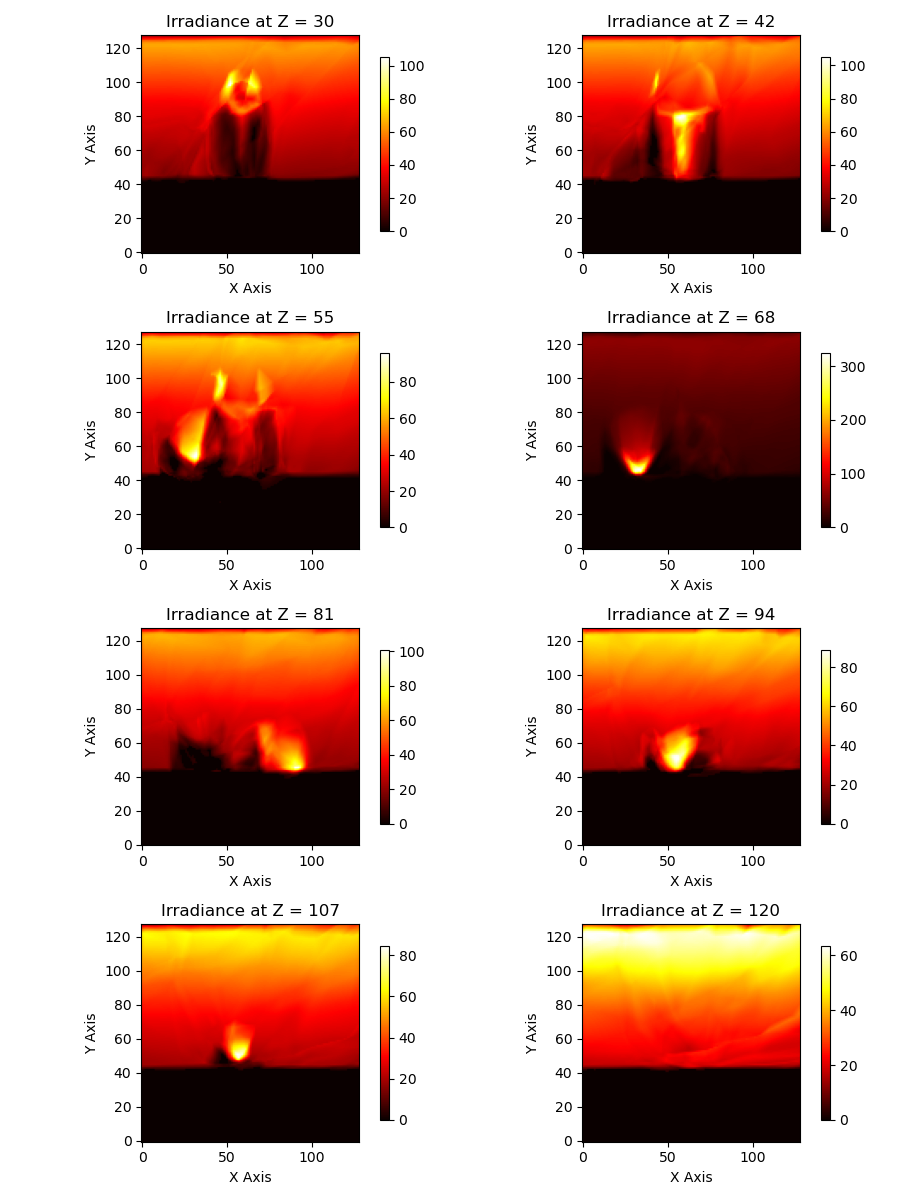

In [30]:
def generate_irradiance_field_3d(model: IrradianceNet, batch_size: int = 2048) -> torch.Tensor:
    x = np.arange(NUM_X)
    y = np.arange(NUM_Y)
    z = np.arange(NUM_Z)
    X, Y, Z = np.meshgrid(x, y, z)
    coords = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)
    
    predictions = []
    with torch.no_grad():
        for i in range(0, len(coords), batch_size):
            batch_coords = coords[i:i+batch_size]
            inputs = torch.tensor(batch_coords, dtype=torch.float32, device=DEVICE)
            batch_predictions = model(inputs)
            predictions.append(batch_predictions)
    
    predictions = torch.cat(predictions)
    return predictions.reshape(NUM_X, NUM_Y, NUM_Z)

# Visualize the predicted irradiance field
predicted_irradiance = generate_irradiance_field_3d(model)
plotter.plot_irradiance_slices(predicted_irradiance.cpu().numpy(), threshold=3, num_slices=8, z_start=30, z_end=120)

## 7. Octree

Number of nodes: 117737
Octree Memory usage: 6593272 bytes
In comparison, NumPy Storage Usage: 8388608 bytes


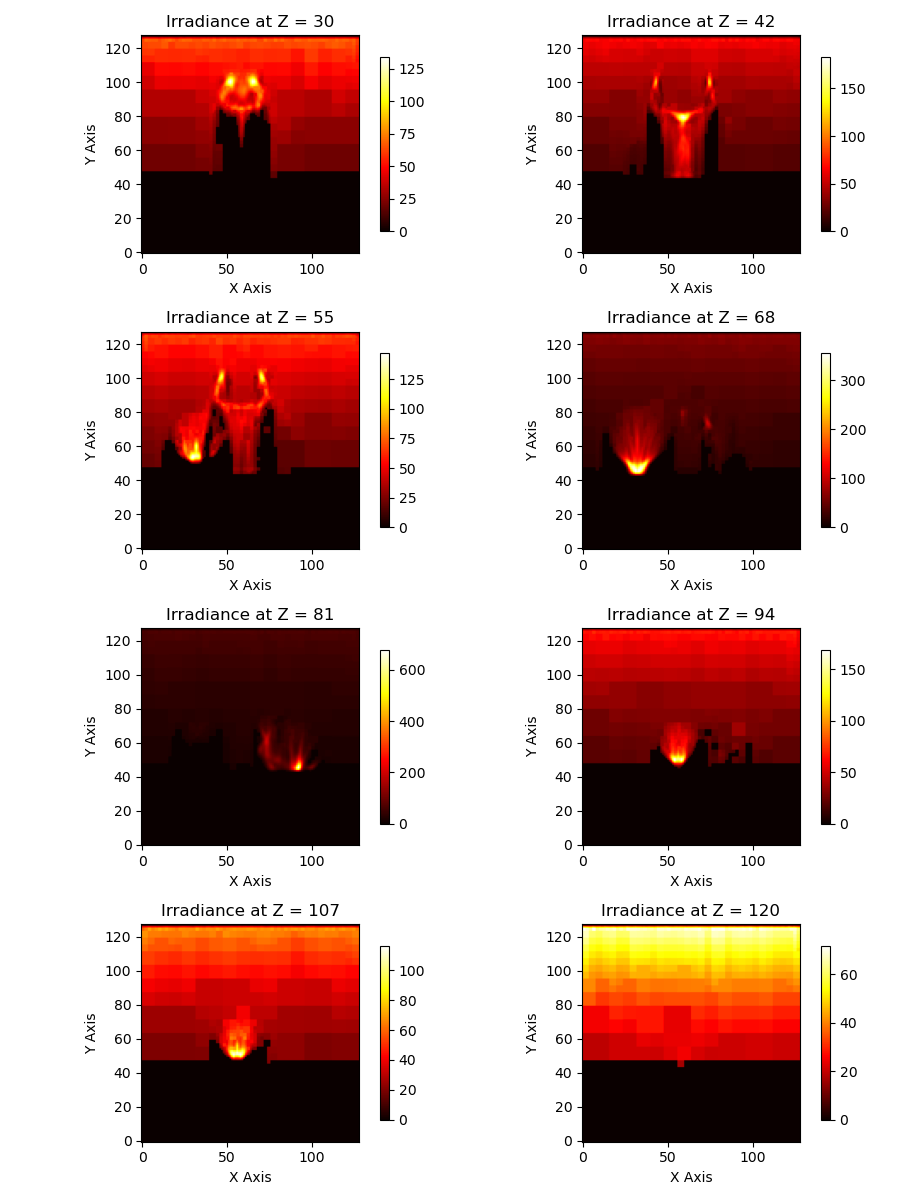

In [25]:
octree = Octree(threshold=int(0.6 * (sampler_multiplier**3)))
octree.construct(scene.irradiance)
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {scene.irradiance.nbytes} bytes")
octree.visualize(plotter)

In [23]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value

5.9942417

## Temp Tests

In [24]:
@ti.data_oriented
class TiArray:
    def __init__(self, n):
        self.x = ti.field(dtype=ti.i32, shape=n)

    @ti.kernel
    def inc(self):
          
        for i in self.x:
            self.x[i] += 1

a = TiArray(32)
a.inc()
print(a.x.to_numpy())
print(a.x.dtype)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
i32


## *. Render